# Lesson2 最適化問題

## 目次
* Section1 物流の最適ルートをコンサルティングする
  * 1.1 物流に関するデータを読み込む
  * 1.2 現状の輸送量、コストを確認する
  * 1.3 ネットワークを可視化する
  * 1.4 ネットワークにノード（頂点）を追加する
  * 1.5 ルートの重みづけを実施する
  * 1.6 輸送ルート情報を読み込む
  * 1.7 輸送ルート情報からネットワークを可視化する
  * 1.8 輸送コスト関数を作成する
  * 1.9 制約条件を作る
  * 1.10 輸送ルートを変更して、輸送コスト関数の変化を確認する
* Section2 ロジスティックネットワークの最適設計を行う
  * 2.1 輸送最適化問題を解いてみよう
  * 2.2 最適輸送ルートをネットワークで確認しよう
  * 2.3 最適輸送ルートが制約条件内に収まっているかどうかを確認する
  * 2.4 生産計画に関するデータを読み込む
  * 2.5 利益を計算する関数を作ってみる
  * 2.6 生産最適化問題を解いてみる
  * 2.7 最適生産計画が制約条件内に収まっているかどうかを確認する
  * 2.8 ロジスティックネットワーク設計問題を解いてみる
  * 2.9 最適ネットワークにおける輸送コストとその内訳を計算する
  * 2.10 最適ネットワークにおける生産コストとその内訳を計算する  
* Section3 数値シミュレーションで消費者行動を予測する
  * 3.1 人間関係のネットワークを可視化する
  * 3.2 口コミによる情報伝搬の様子を可視化する
  * 3.3 口コミ数の時系列変化をグラフ化する
  * 3.4 会員数の時系列変化をシミュレーションする
  * 3.5 パラメータの全体像を、『相図』を見ながら把握する
  * 3.6 実データを読み込む
  * 3.7 リンク数の分布を可視化する
  * 3.8 シミュレーションのために実データからパラメータを推定する
  * 3.9 実データとシミュレーションを比較する
  * 3.10 シミュレーションによる将来予測を実施する 

## Section1
物流のルートを最適化するために最適化問題に取り組みます。おおまかな流れは以下の通りです。

* 最小化または最大化したいを関数（目的関数）を定義する
* 目的関数の最小化または最大化を実現するために必要な制約条件を定義する
* 制約条件を満たしたうえで目的関数を最小化または最大化する組み合わせを選択する

以上が最適化問題の流れ。


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


※MyDrive直下に機械学習プログラムフォルダ全体を格納しておくこと

In [ ]:
%cd drive/MyDrive/機械学習Python研修プログラム/02.研修_2nd_Week_実践編/lesson2/

/content/drive/MyDrive/機械学習Python研修プログラム/02.研修_2nd_Week_実践編/lesson2


In [ ]:
!ls

DATA  lesson2_exercise.ipynb


### 1.1：物流に関するデータを読み込む

In [ ]:
import pandas as pd

# 工場データの読み込み
factories = pd.read_csv("DATA/tbl_factory.csv", index_col=0)
factories

,FCName,FCDemand,FCRegion
FCID,,,
FC00001,東京工場,28,関東
FC00002,木更津工場,29,関東
FC00003,多摩工場,31,関東
FC00004,横須賀工場,25,関東
FC00005,仙台工場,21,東北
FC00006,山形工場,30,東北
FC00007,那須工場,25,東北
FC00008,青森工場,16,東北


In [ ]:
# 倉庫データの読み込み
warehouses = pd.read_csv("DATA/tbl_warehouse.csv", index_col=0)
warehouses

,WHName,WHSupply,WHRegion
WHID,,,
WH00001,杉並倉庫,35,関東
WH00002,品川倉庫,41,関東
WH00003,豊洲倉庫,42,関東
WH00004,郡山倉庫,60,東北
WH00005,仙台倉庫,72,東北
WH00006,山形倉庫,65,東北


In [ ]:
# コストテーブル
cost = pd.read_csv("DATA/rel_cost.csv", index_col=0)
cost.head()

,FCID,WHID,Cost
RCostID,,,
1,FC00001,WH00001,0.4
2,FC00001,WH00002,0.8
3,FC00001,WH00003,1.5
4,FC00002,WH00001,0.9
5,FC00002,WH00002,0.8


In [ ]:
# 輸送トランザクションテーブル
trans = pd.read_csv("DATA/tbl_transaction.csv", index_col=0)
trans.head()

,TransactionDate,ToFC,FromWH,Quantity
TRID,,,,
0,2019-01-01 02:11:10,FC00004,WH00003,33
1,2019-01-01 06:12:42,FC00007,WH00006,19
2,2019-01-01 06:32:32,FC00006,WH00004,31
3,2019-01-01 07:17:06,FC00002,WH00003,18
4,2019-01-01 07:52:18,FC00001,WH00002,30


In [ ]:
# トランザクションテーブルに各テーブルをジョインする
# コストデータを付与
join_data = pd.merge(trans, cost, left_on=["ToFC","FromWH"], right_on=["FCID","WHID"], how="left")
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8


In [ ]:
# 工場情報を付与
join_data = pd.merge(join_data, factories, left_on="ToFC", right_on="FCID", how="left")
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,横須賀工場,25,関東
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3,那須工場,25,東北
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9,山形工場,30,東北
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6,木更津工場,29,関東
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8,東京工場,28,関東


In [ ]:
# 倉庫情報を付与
join_data = pd.merge(join_data, warehouses, left_on="FromWH", right_on="WHID", how="left")
# カラムの並び替え
join_data = join_data[["TransactionDate","Quantity","Cost","ToFC","FCName","FCDemand","FromWH","WHName","WHSupply","WHRegion"]]
join_data.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
1,2019-01-01 06:12:42,19,1.3,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
3,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8,FC00001,東京工場,28,WH00002,品川倉庫,41,関東


In [ ]:
# 関東データを抽出
kanto = join_data.loc[join_data["WHRegion"]=="関東"]
kanto.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
3,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8,FC00001,東京工場,28,WH00002,品川倉庫,41,関東
7,2019-01-01 09:09:30,12,1.5,FC00001,東京工場,28,WH00003,豊洲倉庫,42,関東
8,2019-01-01 10:52:55,27,1.5,FC00003,多摩工場,31,WH00003,豊洲倉庫,42,関東


In [ ]:
# 東北データを抽出
tohoku = join_data.loc[join_data["WHRegion"]=="東北"]
tohoku.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
1,2019-01-01 06:12:42,19,1.3,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
5,2019-01-01 08:56:09,31,0.3,FC00005,仙台工場,21,WH00005,仙台倉庫,72,東北
6,2019-01-01 09:00:15,33,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北
9,2019-01-01 14:12:51,21,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北


### 1.2：現状の輸送量、コストを確認する

In [ ]:
# 支社のコスト合計を算出
print("関東支社の総コスト: " + str(kanto["Cost"].sum()) + "万円")
print("東北支社の総コスト: " + str(tohoku["Cost"].sum()) + "万円")

関東支社の総コスト: 2189.3万円
東北支社の総コスト: 2062.0万円


In [ ]:
# 支社の総輸送個数
print("関東支社の総部品輸送個数: " + str(kanto["Quantity"].sum()) + "個")
print("東北支社の総部品輸送個数: " + str(tohoku["Quantity"].sum()) + "個")

関東支社の総部品輸送個数: 49146個
東北支社の総部品輸送個数: 50214個


In [ ]:
# 部品一つ当たりの輸送コスト
tmp = (kanto["Cost"].sum() / kanto["Quantity"].sum()) * 10000
print("関東支社の部品１つ当たりの輸送コスト: " + str(int(tmp)) + "円")
tmp = (tohoku["Cost"].sum() / tohoku["Quantity"].sum()) * 10000
print("東北支社の部品１つ当たりの輸送コスト: " + str(int(tmp)) + "円")

関東支社の部品１つ当たりの輸送コスト: 445円
東北支社の部品１つ当たりの輸送コスト: 410円


In [ ]:
# コストテーブルを支社ごとに集計
cost_chk = pd.merge(cost, factories, on="FCID", how="left")
# 平均
print("東京支社の平均輸送コスト：" + str(cost_chk["Cost"].loc[cost_chk["FCRegion"]=="関東"].mean()) + "万円")
print("東北支社の平均輸送コスト：" + str(cost_chk["Cost"].loc[cost_chk["FCRegion"]=="東北"].mean()) + "万円")

東京支社の平均輸送コスト：1.075万円
東北支社の平均輸送コスト：1.05万円


### 1.3：ネットワークを可視化する

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# グラフオブジェクトの作成
G=nx.Graph()

# 頂点の設定
G.add_node("nodeA")
G.add_node("nodeB")
G.add_node("nodeC")

# 辺の設定
G.add_edge("nodeA","nodeB")
G.add_edge("nodeA","nodeC")
G.add_edge("nodeB","nodeC")

# 座標の設定
pos={}
pos["nodeA"]=(0,0)
pos["nodeB"]=(1,1)
pos["nodeC"]=(0,1)

# 描画
nx.draw(G,pos)

# 表示
plt.show()

<Figure size 640x480 with 1 Axes>

### 1.4：ネットワークにノードを追加する

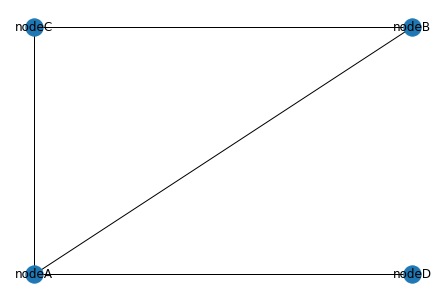

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# グラフオブジェクトの作成．
G=nx.Graph()

# 頂点の設定
G.add_node("nodeA")
G.add_node("nodeB")
G.add_node("nodeC")
G.add_node("nodeD")

# 辺の設定
G.add_edge("nodeA","nodeB")
G.add_edge("nodeA","nodeC")
G.add_edge("nodeB","nodeC")
G.add_edge("nodeA","nodeD")

# 座標の設定
pos={}
pos["nodeA"]=(0,0)
pos["nodeB"]=(1,1)
pos["nodeC"]=(0,1)
pos["nodeD"]=(1,0)

# 描画
nx.draw(G,pos, with_labels=True)

# 表示
plt.show()

### 1.5：ルートの重みづけを実施する

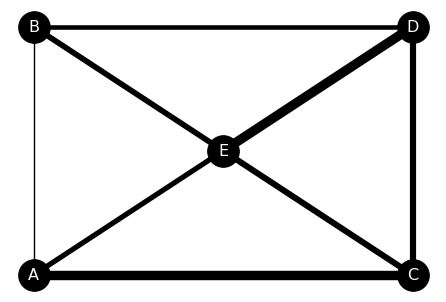

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# データ読み込み
df_w = pd.read_csv('DATA/network_weight.csv')
df_p = pd.read_csv('DATA/network_pos.csv')

# エッジの重みのリスト化
size = 10
edge_weights = []
for i in range(len(df_w)):
    for j in range(len(df_w.columns)):
        edge_weights.append(df_w.iloc[i][j]*size)

# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
for i in range(len(df_w.columns)):
    G.add_node(df_w.columns[i])

# 辺の設定
for i in range(len(df_w.columns)):
    for j in range(len(df_w.columns)):
        G.add_edge(df_w.columns[i],df_w.columns[j])

# 座標の設定
pos = {}
for i in range(len(df_w.columns)):
    node = df_w.columns[i]
    pos[node] = (df_p[node][0],df_p[node][1])

# 描画
nx.draw(G, pos, with_labels=True,font_size=16, node_size = 1000, node_color='k', font_color='w', width=edge_weights)

# 表示
plt.show()

### 1.6：輸送ルート情報を読み込む

In [ ]:
import pandas as pd

# データ読み込み
df_tr = pd.read_csv('DATA/trans_route.csv', index_col="工場")
df_tr.head()


,F1,F2,F3,F4
工場,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


### 1.7：輸送ルート情報からネットワークを可視化する

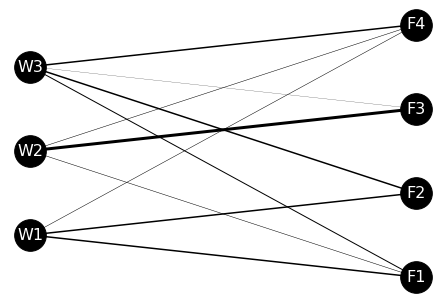

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# データ読み込み
df_tr = pd.read_csv('DATA/trans_route.csv', index_col="工場")
df_pos = pd.read_csv('DATA/trans_route_pos.csv')


# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])

# 辺の設定&エッジの重みのリスト化
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not (i==j):
            # 辺の追加
            G.add_edge(df_pos.columns[i],df_pos.columns[j])
            # エッジの重みの追加
            if num_pre<len(G.edges):
                num_pre = len(G.edges)
                weight = 0
                if (df_pos.columns[i] in df_tr.columns)and(df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]]*size
                elif(df_pos.columns[j] in df_tr.columns)and(df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size
                edge_weights.append(weight)
                

# 座標の設定
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0],df_pos[node][1])
    
# 描画
nx.draw(G, pos, with_labels=True,font_size=16, node_size = 1000, node_color='k', font_color='w', width=edge_weights)

# 表示
plt.show()


### 5.8：輸送コスト関数を作成する

In [ ]:
import pandas as pd

# データ読み込み
df_tr = pd.read_csv('DATA/trans_route.csv', index_col="工場")
df_tc = pd.read_csv('DATA/trans_cost.csv', index_col="工場")

# 輸送コスト関数
def trans_cost(df_tr,df_tc):
    cost = 0
    for i in range(len(df_tc.index)):
        for j in range(len(df_tr.columns)):
            cost += df_tr.iloc[i][j]*df_tc.iloc[i][j]
    return cost

print("総輸送コスト:"+str(trans_cost(df_tr,df_tc)))


総輸送コスト:1493


### 1.9：制約条件を作る

In [ ]:
import pandas as pd

# データ読み込み
df_tr = pd.read_csv('DATA/trans_route.csv', index_col="工場")
df_demand = pd.read_csv('DATA/demand.csv')
df_supply = pd.read_csv('DATA/supply.csv')

# 需要側の制約条件
for i in range(len(df_demand.columns)):
    temp_sum = sum(df_tr[df_demand.columns[i]])
    print(str(df_demand.columns[i])+"への輸送量:"+str(temp_sum)+" (需要量:"+str(df_demand.iloc[0][i])+")")
    if temp_sum>=df_demand.iloc[0][i]:
        print("需要量を満たしています。")
    else:
        print("需要量を満たしていません。輸送ルートを再計算して下さい。")

# 供給側の制約条件
for i in range(len(df_supply.columns)):
    temp_sum = sum(df_tr.loc[df_supply.columns[i]])
    print(str(df_supply.columns[i])+"からの輸送量:"+str(temp_sum)+" (供給限界:"+str(df_supply.iloc[0][i])+")")
    if temp_sum<=df_supply.iloc[0][i]:
        print("供給限界の範囲内です。")
    else:
        print("供給限界を超過しています。輸送ルートを再計算して下さい。")



F1への輸送量:30 (需要量:28)
需要量を満たしています。
F2への輸送量:30 (需要量:29)
需要量を満たしています。
F3への輸送量:32 (需要量:31)
需要量を満たしています。
F4への輸送量:25 (需要量:25)
需要量を満たしています。
W1からの輸送量:35 (供給限界:35)
供給限界の範囲内です。
W2からの輸送量:40 (供給限界:41)
供給限界の範囲内です。
W3からの輸送量:42 (供給限界:42)
供給限界の範囲内です。


### 1.10：輸送ルートを変更して、輸送コスト関数の変化を確認する

In [ ]:
import pandas as pd
import numpy as np

# データ読み込み
df_tr_new = pd.read_csv('DATA/trans_route_new.csv', index_col="工場")
print(df_tr_new)

# 総輸送コスト再計算 
print("総輸送コスト(変更後):"+str(trans_cost(df_tr_new,df_tc)))

# 制約条件計算関数
# 需要側
def condition_demand(df_tr,df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if (temp_sum>=df_demand.iloc[0][i]):
            flag[i] = 1
    return flag
            
# 供給側
def condition_supply(df_tr,df_supply):
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if temp_sum<=df_supply.iloc[0][i]:
            flag[i] = 1
    return flag

print("需要条件計算結果:"+str(condition_demand(df_tr_new,df_demand)))
print("供給条件計算結果:"+str(condition_supply(df_tr_new,df_supply)))

    F1  F2  F3  F4
工場                
W1  15  15   0   0
W2   5   0  30  10
W3  10  15   2  15
総輸送コスト(変更後):1428
需要条件計算結果:[1. 1. 1. 1.]
供給条件計算結果:[1. 0. 1.]


### 2.1：輸送最適化問題を解く

In [ ]:
!pip install pulp
!pip install ortoolpy

In [ ]:
import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals

# データ読み込み
df_tc = pd.read_csv('DATA/trans_cost.csv', index_col="工場")
df_demand = pd.read_csv('DATA/demand.csv')
df_supply = pd.read_csv('DATA/supply.csv')

# 初期設定 #
np.random.seed(1)
nw = len(df_tc.index)
nf = len(df_tc.columns)
pr = list(product(range(nw), range(nf)))

# 数理モデル作成 #
m1 = model_min()
v1 = {(i,j):LpVariable('v%d_%d'%(i,j),lowBound=0) for i,j in pr}

m1 += lpSum(df_tc.iloc[i][j]*v1[i,j] for i,j in pr)
for i in range(nw):
    m1 += lpSum(v1[i,j] for j in range(nf)) <= df_supply.iloc[0][i]
for j in range(nf):
    m1 += lpSum(v1[i,j] for i in range(nw)) >= df_demand.iloc[0][j]
m1.solve()

# 総輸送コスト計算 #
df_tr_sol = df_tc.copy()
total_cost = 0
for k,x in v1.items():
    i,j = k[0],k[1]
    df_tr_sol.iloc[i][j] = value(x)
    total_cost += df_tc.iloc[i][j]*value(x)
    
print(df_tr_sol)
print("総輸送コスト:"+str(total_cost))

    F1  F2  F3  F4
工場                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
総輸送コスト:1296.0


### 2.2：最適輸送ルートをネットワークで確認する

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# データ読み込み
df_tr = df_tr_sol.copy()
df_pos = pd.read_csv('DATA/trans_route_pos.csv')

# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])

# 辺の設定&エッジの重みのリスト化
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not (i==j):
            # 辺の追加
            G.add_edge(df_pos.columns[i],df_pos.columns[j])
            # エッジの重みの追加
            if num_pre<len(G.edges):
                num_pre = len(G.edges)
                weight = 0
                if (df_pos.columns[i] in df_tr.columns)and(df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]]*size
                elif(df_pos.columns[j] in df_tr.columns)and(df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size
                edge_weights.append(weight)
                

# 座標の設定
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0],df_pos[node][1])
    
# 描画
nx.draw(G, pos, with_labels=True,font_size=16, node_size = 1000, node_color='k', font_color='w', width=edge_weights)

# 表示
plt.show()

### 2.3：最適輸送ルートが制約条件内に収まっているかどうかを確認する

In [ ]:
import pandas as pd
import numpy as np

# データ読み込み
df_demand = pd.read_csv('DATA/demand.csv')
df_supply = pd.read_csv('DATA/supply.csv')

# 制約条件計算関数
# 需要側
def condition_demand(df_tr,df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if (temp_sum>=df_demand.iloc[0][i]):
            flag[i] = 1
    return flag
            
# 供給側
def condition_supply(df_tr,df_supply):
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if temp_sum<=df_supply.iloc[0][i]:
            flag[i] = 1
    return flag

print("需要条件計算結果:"+str(condition_demand(df_tr_sol,df_demand)))
print("供給条件計算結果:"+str(condition_supply(df_tr_sol,df_supply)))

需要条件計算結果:[1. 1. 1. 1.]
供給条件計算結果:[1. 1. 1.]


### 2.4：生産計画に関するデータを読み込む

In [ ]:
import pandas as pd

df_material = pd.read_csv('DATA/product_plan_material.csv', index_col="製品")
print(df_material)
df_profit = pd.read_csv('DATA/product_plan_profit.csv', index_col="製品")
print(df_profit)
df_stock = pd.read_csv('DATA/product_plan_stock.csv', index_col="項目")
print(df_stock)
df_plan = pd.read_csv('DATA/product_plan.csv', index_col="製品")
print(df_plan)

     原料1  原料2  原料3
製品                
製品1    1    4    3
製品2    2    4    1
      利益
製品      
製品1  5.0
製品2  4.0
    原料1  原料2  原料3
項目               
在庫   40   80   50
      生産量
製品       
製品1    16
製品2     0


### 2.5：利益を計算する関数を作る

In [ ]:
# 利益計算関数
def product_plan(df_profit,df_plan):
    profit = 0
    for i in range(len(df_profit.index)):
        for j in range(len(df_plan.columns)):
            profit += df_profit.iloc[i][j]*df_plan.iloc[i][j]
    return profit

print("総利益:"+str(product_plan(df_profit,df_plan)))

総利益:80.0


### 2.6：生産最適化問題を解く


In [ ]:
import pandas as pd
from pulp import LpVariable, lpSum, value
from ortoolpy import model_max, addvars, addvals


df = df_material.copy()
inv = df_stock

m = model_max()
v1 = {(i):LpVariable('v%d'%(i),lowBound=0) for i in range(len(df_profit))}
m += lpSum(df_profit.iloc[i]*v1[i] for i in range(len(df_profit)))
for i in range(len(df_material.columns)):
    m += lpSum(df_material.iloc[j,i]*v1[j] for j in range(len(df_profit)) ) <= df_stock.iloc[:,i]
m.solve()

df_plan_sol = df_plan.copy()
for k,x in v1.items():
    df_plan_sol.iloc[k] = value(x)
print(df_plan_sol)
print("総利益:"+str(value(m.objective)))

      生産量
製品       
製品1  15.0
製品2   5.0
総利益:95.0


### 2.7：最適生産計画が制約条件内に収まっているかどうかを確認する

In [ ]:
# 制約条件計算関数
def condition_stock(df_plan,df_material,df_stock):
    flag = np.zeros(len(df_material.columns))
    for i in range(len(df_material.columns)):  
        temp_sum = 0
        for j in range(len(df_material.index)):  
            temp_sum = temp_sum + df_material.iloc[j][i]*float(df_plan.iloc[j])
        if (temp_sum<=float(df_stock.iloc[0][i])):
            flag[i] = 1
        print(df_material.columns[i]+"  使用量:"+str(temp_sum)+", 在庫:"+str(float(df_stock.iloc[0][i])))
    return flag

print("制約条件計算結果:"+str(condition_stock(df_plan_sol,df_material,df_stock)))

原料1  使用量:25.0, 在庫:40.0
原料2  使用量:80.0, 在庫:80.0
原料3  使用量:50.0, 在庫:50.0
制約条件計算結果:[1. 1. 1.]


### 2.8：ロジスティクスネットワーク設計問題を解く

In [ ]:
import numpy as np
import pandas as pd

製品 = list('AB')
需要地 = list('PQ')
工場 = list('XY')
レーン = (2,2)

# 輸送費表 #
tbdi = pd.DataFrame(((j,k) for j in 需要地 for k in 工場), columns=['需要地','工場'])
tbdi['輸送費'] = [1,2,3,1]
print(tbdi)

# 需要表 #
tbde = pd.DataFrame(((j,i) for j in 需要地 for i in 製品), columns=['需要地','製品'])
tbde['需要'] = [10,10,20,20]
print(tbde)

# 生産表 #
tbfa = pd.DataFrame(((k,l,i,0,np.inf) for k,nl in zip (工場,レーン) for l in range(nl) for i in 製品), 
                    columns=['工場','レーン','製品','下限','上限'])
tbfa['生産費'] = [1,np.nan,np.nan,1,3,np.nan,5,3]
tbfa.dropna(inplace=True)
tbfa.loc[4,'上限']=10
print(tbfa)

from ortoolpy import logistics_network
_, tbdi2, _ = logistics_network(tbde,tbdi,tbfa)
print(tbfa)
print(tbdi2)

  需要地 工場  輸送費
0   P  X    1
1   P  Y    2
2   Q  X    3
3   Q  Y    1
  需要地 製品  需要
0   P  A  10
1   P  B  10
2   Q  A  20
3   Q  B  20
  工場  レーン 製品  下限    上限  生産費
0  X    0  A   0   inf  1.0
3  X    1  B   0   inf  1.0
4  Y    0  A   0  10.0  3.0
6  Y    1  A   0   inf  5.0
7  Y    1  B   0   inf  3.0
  工場  レーン 製品  下限    上限  生産費     VarY  ValY
0  X    0  A   0   inf  1.0  v000009  20.0
3  X    1  B   0   inf  1.0  v000010  10.0
4  Y    0  A   0  10.0  3.0  v000011  10.0
6  Y    1  A   0   inf  5.0  v000012   0.0
7  Y    1  B   0   inf  3.0  v000013  20.0
  需要地 工場  輸送費 製品     VarX  ValX
0   P  X    1  A  v000001  10.0
1   P  X    1  B  v000002  10.0
2   Q  X    3  A  v000003  10.0
3   Q  X    3  B  v000004   0.0
4   P  Y    2  A  v000005   0.0
5   P  Y    2  B  v000006   0.0
6   Q  Y    1  A  v000007  10.0
7   Q  Y    1  B  v000008  20.0


### 2.9：最適ネットワークにおける輸送コストとその内訳を計する

In [ ]:
print(tbdi2)
trans_cost = 0
for i in range(len(tbdi2.index)):
    trans_cost += tbdi2["輸送費"].iloc[i]*tbdi2["ValX"].iloc[i]
print("総輸送コスト:"+str(trans_cost))

  需要地 工場  輸送費 製品     VarX  ValX
0   P  X    1  A  v000001  10.0
1   P  X    1  B  v000002  10.0
2   Q  X    3  A  v000003  10.0
3   Q  X    3  B  v000004   0.0
4   P  Y    2  A  v000005   0.0
5   P  Y    2  B  v000006   0.0
6   Q  Y    1  A  v000007  10.0
7   Q  Y    1  B  v000008  20.0
総輸送コスト:80.0


### 2.10：最適ネットワークにおける生産コストとその内訳を計算する

In [ ]:
print(tbfa)
product_cost = 0
for i in range(len(tbfa.index)):
    product_cost += tbfa["生産費"].iloc[i]*tbfa["ValY"].iloc[i]
print("総生産コスト:"+str(product_cost))

  工場  レーン 製品  下限    上限  生産費     VarY  ValY
0  X    0  A   0   inf  1.0  v000009  20.0
3  X    1  B   0   inf  1.0  v000010  10.0
4  Y    0  A   0  10.0  3.0  v000011  10.0
6  Y    1  A   0   inf  5.0  v000012   0.0
7  Y    1  B   0   inf  3.0  v000013  20.0
総生産コスト:120.0


### 3.1：人間関係のネットワークを可視化する

In [ ]:
import pandas as pd

df_links = pd.read_csv("DATA/links.csv")
df_links

,Unnamed: 0,Node0,Node1,Node2,Node3,Node4,Node5,Node6,Node7,Node8,...,Node10,Node11,Node12,Node13,Node14,Node15,Node16,Node17,Node18,Node19
0,Node0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Node1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Node2,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Node3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Node4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,Node5,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,Node6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,Node7,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,Node8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
9,Node9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
NUM = len(df_links.index)
for i in range(1,NUM+1):
    node_no = df_links.columns[i].strip("Node")
    G.add_node(str(node_no))

# 辺の設定
for i in range(NUM):
    for j in range(NUM):
        node_name = "Node" + str(j)
        if df_links[node_name].iloc[i]==1:
            G.add_edge(str(i),str(j))
        
# 描画 
nx.draw_networkx(G,node_color="k", edge_color="k", font_color="w")
plt.show()

<Figure size 640x480 with 1 Axes>

### 3.2：口コミによる情報伝播の様子を可視化する

In [ ]:
import numpy as np

In [ ]:
def determine_link(percent):
    rand_val = np.random.rand()
    if rand_val<=percent:
        return 1
    else:
        return 0

In [ ]:
def simulate_percolation(num, list_active, percent_percolation):
    for i in range(num):
        if list_active[i]==1:
            for j in range(num):
                node_name = "Node" + str(j)
                if df_links[node_name].iloc[i]==1:
                    if determine_link(percent_percolation)==1:
                        list_active[j] = 1
    return list_active

In [ ]:
percent_percolation = 0.1
T_NUM = 36
NUM = len(df_links.index)
list_active = np.zeros(NUM)
list_active[0] = 1

list_timeSeries = []
for t in range(T_NUM):
    list_active = simulate_percolation(NUM, list_active, percent_percolation)
    list_timeSeries.append(list_active.copy())

In [ ]:
# アクティブノード可視化 #
def active_node_coloring(list_active):
    #print(list_timeSeries[t])
    list_color = []
    for i in range(len(list_timeSeries[t])):
        if list_timeSeries[t][i]==1:
            list_color.append("r")
        else:
            list_color.append("k")
    #print(len(list_color))
    return list_color

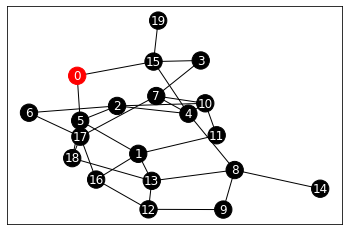

In [ ]:
# 描画
t = 0
nx.draw_networkx(G,font_color="w",node_color=active_node_coloring(list_timeSeries[t]))
plt.show()

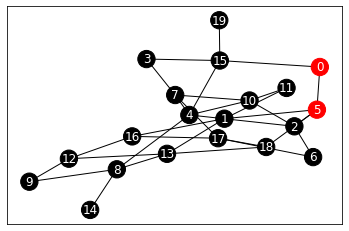

In [ ]:
# 描画
t = 11
nx.draw_networkx(G,font_color="w",node_color=active_node_coloring(list_timeSeries[t]))
plt.show()

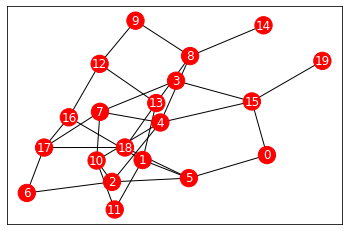

In [ ]:
# 描画
t = 35
nx.draw_networkx(G,font_color="w",node_color=active_node_coloring(list_timeSeries[t]))
plt.show()

### 3.3：口コミ数の時系列変化をグラフ化する

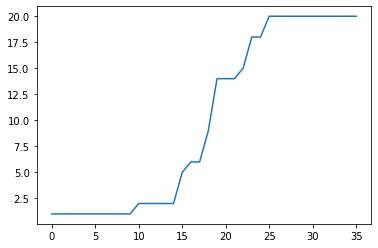

In [ ]:
# 時系列グラフを描く
list_timeSeries_num = []
for i in range(len(list_timeSeries)):
    list_timeSeries_num.append(sum(list_timeSeries[i]))

plt.plot(list_timeSeries_num)
plt.show()

### 3.4：会員数の時系列変化をシミュレーションする

In [ ]:
def simulate_population(num, list_active, percent_percolation, percent_disapparence,df_links):
    # 拡散 #
    for i in range(num):
        if list_active[i]==1:
            for j in range(num):
                if df_links.iloc[i][j]==1:
                    if determine_link(percent_percolation)==1:
                        list_active[j] = 1
    # 消滅 #
    for i in range(num):
        if determine_link(percent_disapparence)==1:
            list_active[i] = 0
    return list_active

In [ ]:
percent_percolation = 0.1
percent_disapparence = 0.05
T_NUM = 100
NUM = len(df_links.index)
list_active = np.zeros(NUM)
list_active[0] = 1

list_timeSeries = []
for t in range(T_NUM):
    list_active = simulate_population(NUM, list_active, percent_percolation, percent_disapparence,df_links)
    list_timeSeries.append(list_active.copy())

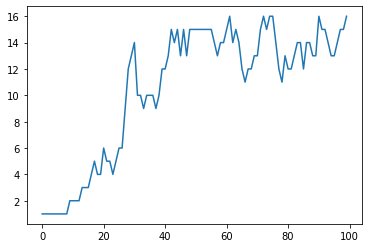

In [ ]:
# 時系列グラフを描く
list_timeSeries_num = []
for i in range(len(list_timeSeries)):
    list_timeSeries_num.append(sum(list_timeSeries[i]))

plt.plot(list_timeSeries_num)
plt.show()

In [ ]:
percent_disapparence = 0.2
list_active = np.zeros(NUM)
list_active[0] = 1
list_timeSeries = []
for t in range(T_NUM):
    list_active = simulate_population(NUM, list_active, percent_percolation, percent_disapparence,df_links)
    list_timeSeries.append(list_active.copy())

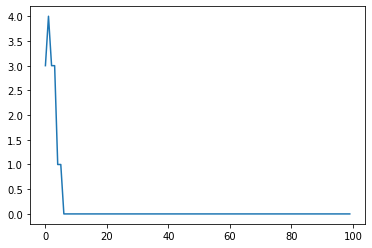

In [ ]:
# 時系列グラフを描く
list_timeSeries_num = []
for i in range(len(list_timeSeries)):
    list_timeSeries_num.append(sum(list_timeSeries[i]))

plt.plot(list_timeSeries_num)
plt.show()

### 3.5：パラメータの全体像を相図を見ながら把握する

In [ ]:
# 相図計算
print("相図計算開始")
T_NUM = 100
NUM_PhaseDiagram = 20
phaseDiagram = np.zeros((NUM_PhaseDiagram,NUM_PhaseDiagram))
for i_p in range(NUM_PhaseDiagram):
    for i_d in range(NUM_PhaseDiagram):
        percent_percolation = 0.05*i_p
        percent_disapparence = 0.05*i_d
        list_active = np.zeros(NUM)
        list_active[0] = 1
        for t in range(T_NUM):
            list_active = simulate_population(NUM, list_active, percent_percolation, percent_disapparence,df_links)
        phaseDiagram[i_p][i_d] = sum(list_active)
print(phaseDiagram)

相図計算開始
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [14.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 16.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 17. 16. 13.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 17. 15. 13.  6.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 19.  0. 14. 15.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 16. 17. 13. 14.  0.  9.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 19. 15. 13. 15.  8.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 17. 16. 14. 10.  0.  0.  0.  9. 10.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 17. 16. 16.  0.  0.  0.  0.  9. 10.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20.  0. 19. 15. 16. 12. 14.  9.  0.  0.  0.  0.  0.  0. 

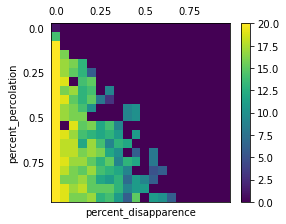

In [ ]:
# 表示
plt.matshow(phaseDiagram)
plt.colorbar(shrink=0.8)
plt.xlabel('percent_disapparence')
plt.ylabel('percent_percolation')
plt.xticks(np.arange(0.0, 20.0,5), np.arange(0.0, 1.0, 0.25))
plt.yticks(np.arange(0.0, 20.0,5), np.arange(0.0, 1.0, 0.25))
plt.tick_params(bottom=False,
                left=False,
                right=False,
                top=False)
plt.show()

### 3.6：実データを読み込む

In [ ]:
import pandas as pd

df_mem_links = pd.read_csv("DATA/links_members.csv")
df_mem_info = pd.read_csv("DATA/info_members.csv")

### 3.7：リンク数の分布を可視化する

In [ ]:
NUM = len(df_mem_links.index)
array_linkNum = np.zeros(NUM)
for i in range(NUM):
    array_linkNum[i] = sum(df_mem_links["Node"+str(i)])

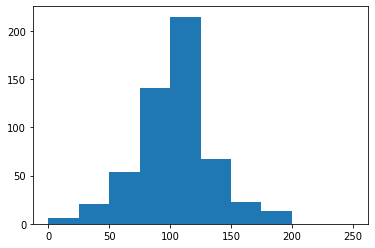

In [ ]:
plt.hist(array_linkNum, bins=10,range=(0,250))
plt.show()

### 3.8：シミュレーションのために実データからパラメータを推定する

In [ ]:
NUM = len(df_mem_info.index)
T_NUM = len(df_mem_info.columns)-1
# 消滅の確率推定 #
count_active = 0
count_active_to_inactive = 0
for t in range(1,T_NUM):
    for i in range(NUM):
        if (df_mem_info.iloc[i][t]==1):
            count_active_to_inactive += 1
            if (df_mem_info.iloc[i][t+1]==0):
                count_active += 1
estimated_percent_disapparence = count_active/count_active_to_inactive

In [ ]:
# 拡散の確率推定 #
count_link = 0
count_link_to_active = 0
count_link_temp = 0
for t in range(T_NUM-1):
    df_link_t = df_mem_info[df_mem_info[str(t)]==1]
    temp_flag_count = np.zeros(NUM)
    for i in range(len(df_link_t.index)):
        df_link_temp = df_mem_links[df_mem_links["Node"+str(df_link_t.index[i])]==1]
        for j in range(len(df_link_temp.index)):
            if (df_mem_info.iloc[df_link_temp.index[j]][t]==0):
                if (temp_flag_count[df_link_temp.index[j]]==0):
                    count_link += 1
                if (df_mem_info.iloc[df_link_temp.index[j]][t+1]==1):
                    if (temp_flag_count[df_link_temp.index[j]]==0):
                        temp_flag_count[df_link_temp.index[j]] = 1 
                        count_link_to_active += 1
estimated_percent_percolation = count_link_to_active/count_link

In [ ]:
estimated_percent_disapparence

0.10147163541419416

In [ ]:
estimated_percent_percolation

0.025184661323275185

### 3.9：実データとシミュレーションを比較する

In [ ]:
percent_percolation = 0.025184661323275185
percent_disapparence = 0.10147163541419416
T_NUM = 24
NUM = len(df_mem_links.index)
list_active = np.zeros(NUM)
list_active[0] = 1
list_timeSeries = []
for t in range(T_NUM):
    list_active = simulate_population(NUM, list_active, percent_percolation, percent_disapparence,df_mem_links)
    list_timeSeries.append(list_active.copy())

In [ ]:
list_timeSeries_num = []
for i in range(len(list_timeSeries)):
    list_timeSeries_num.append(sum(list_timeSeries[i]))

In [ ]:
T_NUM = len(df_mem_info.columns)-1
list_timeSeries_num_real = []
for t in range(0,T_NUM):
    list_timeSeries_num_real.append(len(df_mem_info[df_mem_info[str(t)]==1].index))

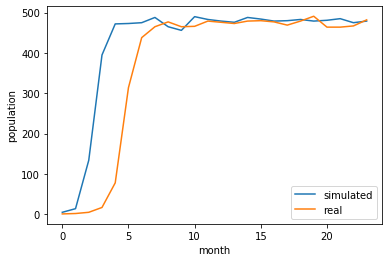

In [ ]:
plt.plot(list_timeSeries_num, label = 'simulated')
plt.plot(list_timeSeries_num_real, label = 'real')
plt.xlabel('month')
plt.ylabel('population')
plt.legend(loc='lower right')
plt.show()

### 3.10：シミュレーションによる将来予測を実施する

In [ ]:
percent_percolation = 0.025184661323275185
percent_disapparence = 0.10147163541419416
T_NUM = 36
NUM = len(df_mem_links.index)
list_active = np.zeros(NUM)
list_active[0] = 1
list_timeSeries = []
for t in range(T_NUM):
    list_active = simulate_population(NUM, list_active, percent_percolation, percent_disapparence,df_mem_links)
    list_timeSeries.append(list_active.copy())

In [ ]:
list_timeSeries_num = []
for i in range(len(list_timeSeries)):
    list_timeSeries_num.append(sum(list_timeSeries[i]))

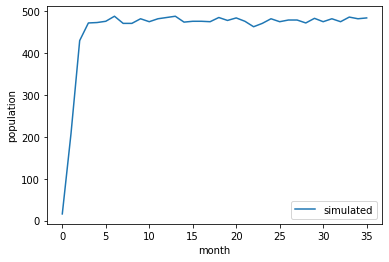

In [ ]:
plt.plot(list_timeSeries_num, label = 'simulated')
plt.xlabel('month')
plt.ylabel('population')
plt.legend(loc='lower right')
plt.show()